In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import MapModule
from GraphicalUtils import Point,Edge,Graph,Square,Point_Type
from pprint import pprint
import random
import pickle
import os
from SearchingAlgorithems import Dijkstra

## Get full map of Israel
this map will use us to get every sub area in israel and present the points and the flying routes

In [2]:
# ISRAEL_MAP_FILE_NAME = 'israel_map.pkl'
# full_map:MapModule.Map = None
# if(os.path.exists(ISRAEL_MAP_FILE_NAME)):
#     with open(ISRAEL_MAP_FILE_NAME, 'rb') as file:
#         full_map = pickle.load(file)
# else:
#     full_map= MapModule.get_full_israel_map()
#     with open(ISRAEL_MAP_FILE_NAME, 'wb') as file:
#         pickle.dump(full_map, file)

full_map= MapModule.get_full_israel_map()


In [3]:
#map = MapModule.print_map(full_map)

## Get map of Tel Aviv area
from the full Israel map we will crop smaller area of tel aviv

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


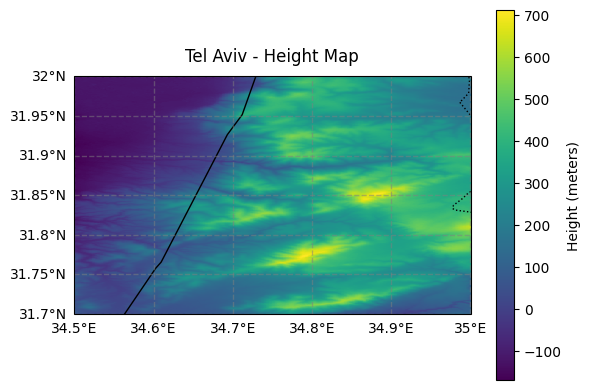

In [4]:
cropped_map = full_map.crop(Point(34.5,31.7),Point(35,32))
map = cropped_map.print()

## Define Pharmecy locations and Costumers location


In the next cell we will define static list of points that represents pharmecies that mark with blue points and static list of static list of yellow points that represent costumers's houses locations

In [5]:
pharmecy_color = 'blue'
costumer_color = 'yellow'

In [6]:
pharmecy_locations = [
    Point(31.9,34.7,color=pharmecy_color,point_type=Point_Type.PHARMECY),
    Point(31.9,34.85,color=pharmecy_color,point_type=Point_Type.PHARMECY),
    Point(31.71,34.73,color=pharmecy_color,point_type=Point_Type.PHARMECY),
    Point(31.812,34.856,color=pharmecy_color,point_type=Point_Type.PHARMECY),
    Point(31.9,34.9,color=pharmecy_color,point_type=Point_Type.PHARMECY)
]

In [7]:
costumers_locations = [
    Point(31.84,34.7,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.9,34.85,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.8,34.73,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.754,34.654,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.845,34.767,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.745,34.864,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.912,34.756,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.8,34.87,color=costumer_color,point_type=Point_Type.COSTUMER)
]

In [8]:
no_fly_zones = [
    Square(Point(32,34.5),Point(31.95,34.7)),
    Square(Point(31.95,34.5),Point(31.9,34.67)),
    Square(Point(31.9,34.5),Point(31.85,34.65)),
    Square(Point(31.85,34.5),Point(31.8,34.62)),
    Square(Point(31.8,34.5),Point(31.75,34.6)),
    Square(Point(31.75,34.5),Point(31.7,34.58)),
    Square(Point(31.887,34.69),Point(31.878,34.715)),
    #Square(Point(32,34.92),Point(31.7,34.5)),
    Square(Point(31.89,34.78),Point(31.87,34.9)),
    Square(Point(31.82,34.77),Point(31.7,34.82)),
    Square(Point(31.82,34.66),Point(31.8,34.7)),
    Square(Point(31.77,34.68),Point(31.7,34.695))
]

In [9]:
cropped_map.marked_graph.add_points(pharmecy_locations)

In [10]:
cropped_map.marked_graph.add_points(costumers_locations)

In [11]:
cropped_map.no_fly_zones.extend(no_fly_zones)

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

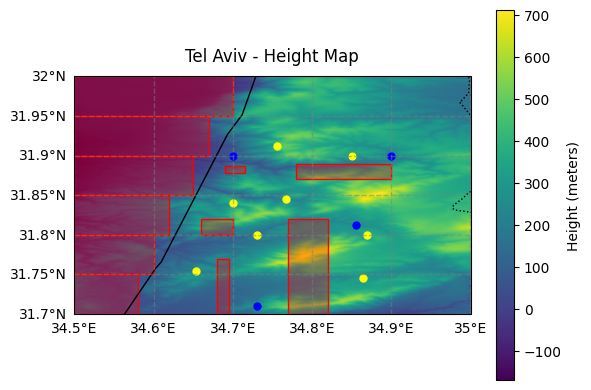

In [12]:
cropped_map.print()

# Sortest path searching

In the next cells we will try to find the shortest path from costumer to the nearst pharmecy

## PRM

In this section Ill we run the first parts of PRM algoritem.
1) Randomaly generate point over the mao
2) delete every point the located in no flight zone
3) connect all the generated point to each other and creat new edges
4) cennect the generated points to each costumer point and create new ages
5) repeat each step foreach pharmacy
6) deleate each edge that pass over no flight zode

### Randomly genarate N new point over the map 

In [13]:
def generate_N_points(N,map:MapModule.Map) ->list[Point]:
    generated_points: list[Point] = []
    max_y, min_x , min_y, max_x = map.bounds

    for i in range(N):
        rand_x = random.uniform(min_x,max_x)
        rand_y = random.uniform(min_y,max_y)
        generated_points.append(Point(rand_x,rand_y,color='black',size=1))
    return generated_points


In [14]:
N = 50
generated_points = generate_N_points(N,cropped_map)
cropped_map.marked_graph.add_points(generated_points)

In [15]:
def set_z_value_for_points(map:MapModule.Map,points:list[Point]):
    for p in points:
        p.z = map.get_height_at_point(Point(p.y,p.x))
set_z_value_for_points(cropped_map,cropped_map.marked_graph.points)

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

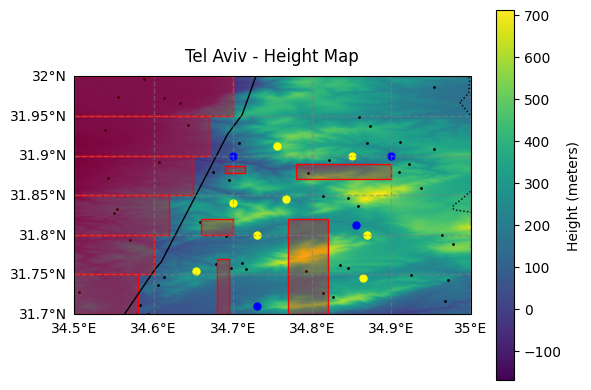

In [16]:
cropped_map.print()

### Delete each point that locatd in no flight zode

In [17]:
def delete_points_from_squers(map:MapModule.Map):
    for zone in map.no_fly_zones:
        for point in map.marked_graph.points:
            if zone.is_inside(point):
                map.marked_graph.points.remove(point)
                map.delete_element(point)

delete_points_from_squers(cropped_map)

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

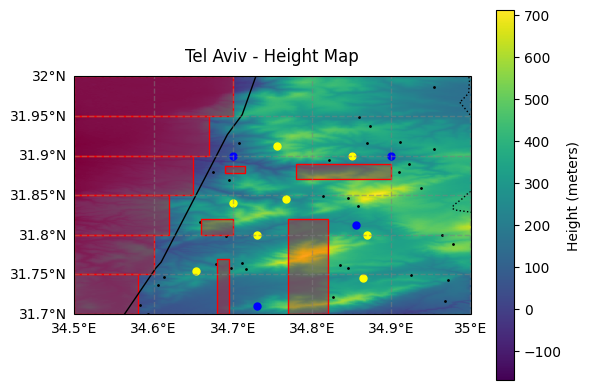

In [18]:
cropped_map.print()

### Conect generated point to each other 

In [19]:
def connect_edges_between_points(points: list[Point],color,thickness = 0.5) -> list[Edge]:
    edges: list[Edge] = []
    for p1 in points:
        for p2 in points:
            if p1 == p2: continue
            if(p1.type == Point_Type.COSTUMER and p2.type == Point_Type.COSTUMER): continue
            if(p1.type == Point_Type.PHARMECY and p2.type == Point_Type.PHARMECY): continue
            edges.append(Edge(p1,p2,color,thickness))
    return edges




In [20]:
edges_list:list[Edge] = connect_edges_between_points(cropped_map.marked_graph.points,'red',0.05)
cropped_map.marked_graph.add_adges(edges_list)



c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

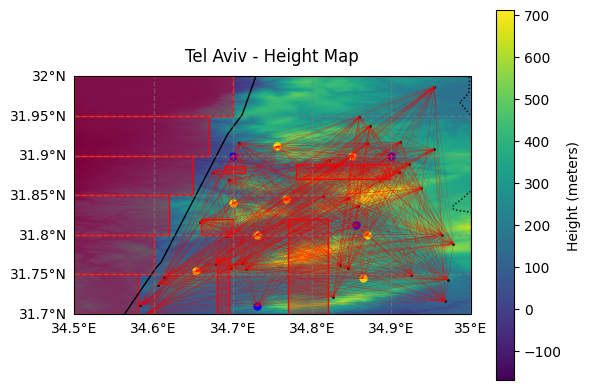

In [21]:
cropped_map.print()

### Deleate each edge that cross no fly area

In [22]:
def deleate_all_no_fly_zones_crossing_edges(map:MapModule.Map,zones:list[Square],edges:list[Edge]):
    for zone in no_fly_zones:
        for edge in edges:
            if(zone.is_edge_crossing(edge)):
                edges.remove(edge)
                continue
                #map.delete_element(edge)


In [23]:
for i in range(4):
    deleate_all_no_fly_zones_crossing_edges(cropped_map,cropped_map.no_fly_zones,cropped_map.marked_graph.edges)

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

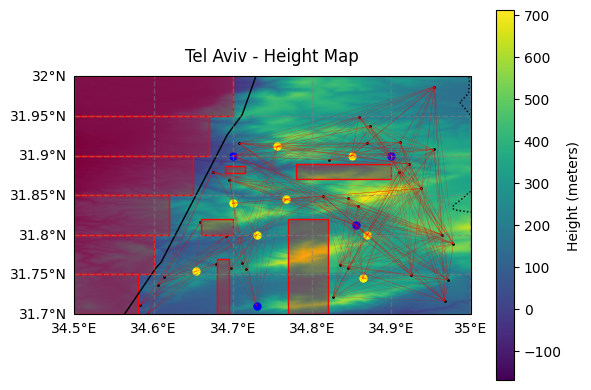

In [24]:
cropped_map.print()

This is out final graph, Now we can move to the second part of finding the sortest path between the points

## Sortest path finding

In this section I will implement 2 grapg searching algorithems, Dijaksta and A*.
then we can compare between them

I Want to find the shortest path for the nearest pharmecy

### Dijakstra

In [56]:
costumers_points = [p for p in cropped_map.marked_graph.points if p.type == Point_Type.COSTUMER]
pharmecy_points = [p for p in cropped_map.marked_graph.points if p.type == Point_Type.PHARMECY]
#setup dijakstra algorithem for ant costumer
algorithems = {point: Dijkstra(cropped_map.marked_graph,point) for point in costumers_points}

nearest_pharmecy = {point: (None,math.inf,[]) for point in costumers_points}
#run each algorithem
for costtumer in algorithems:
    algorithems[costtumer].run()

    min_distance = math.inf
    #list of distances to all fharmecy from curren costumer
    for pharmecy in [p for p in algorithems[costtumer].distances if p.type ==Point_Type.PHARMECY]:
        current_cost = algorithems[costtumer].distances[pharmecy]
        if current_cost  < min_distance:
            min_distance = current_cost
            nearest_pharmecy[costtumer] = (pharmecy,current_cost)

           

TypeError: can only concatenate tuple (not "list") to tuple

err


c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

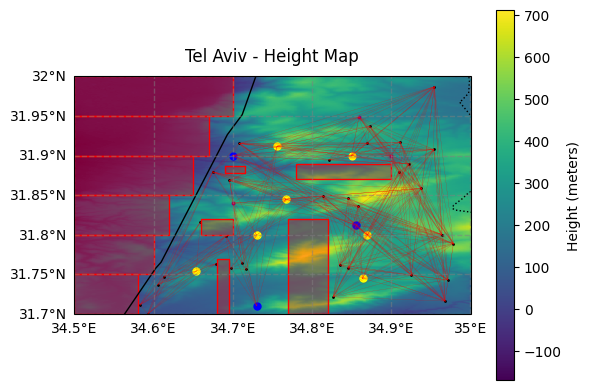

In [60]:

for costtumer in costumers_points:
    for point in algorithems[costtumer].get_shortest_path(nearest_pharmecy[costtumer][0]):
        cropped_map.marked_graph.points.remove(point)
        cropped_map.marked_graph.add_point(Point(point.x,point.y,point.z,"purple",3,point.type))


cropped_map.print()